In [1]:
import os
import torch
import pickle
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import random

from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter

from models import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(41)

In [4]:
model_name = 'AirNet'+'_'+'AlphabetComplete'
dataset_names = ['Alphabet_Salar', 'Alphabet_Aref']
# dataset_names = ['HumanActivity'] , 'Alphabet_Aref'
feature_extraction = True

In [5]:
label_encoder = LabelEncoder()

y = []
for i, dataset_name in enumerate(dataset_names):
    full_path = 'Datasets'+'/'+dataset_name+'.npz'
    dataset = np.load(full_path)
    if i==0:
        x = dataset['x']
    else:
        x = np.concatenate([x, dataset['x']], axis=0)
    y += list(dataset['y'])

x = np.array(x)
ndata, ntimestep, nchannels  = x.shape


In [6]:
# classes = ['ADL:Walking', 'ADL:Running', 'ADL:Jumping', 'ADL:StandtoSit', 'ADL:SittoStand', 'ADL:Upstairs', 'ADL:Downstairs', 'ADL:StandtoLie', 'ADL:LietoStand']
# for i in range(len(y)):
#     y[i] = classes[y[i]]
#     # if(y[i] == 'ADL:Jumpying'):
#     #     y[i] = 'ADL:Jumping'
# full_path = 'Datasets/HumanActivity1.npz'
# np.savez(full_path, x=x, y=y)

In [7]:
y = label_encoder.fit_transform(y)
nclasses = len(label_encoder.classes_)
print(f'ndata: {ndata} , ntimestep: {ntimestep} , nchannels: {nchannels}')

ndata: 2325 , ntimestep: 2048 , nchannels: 6


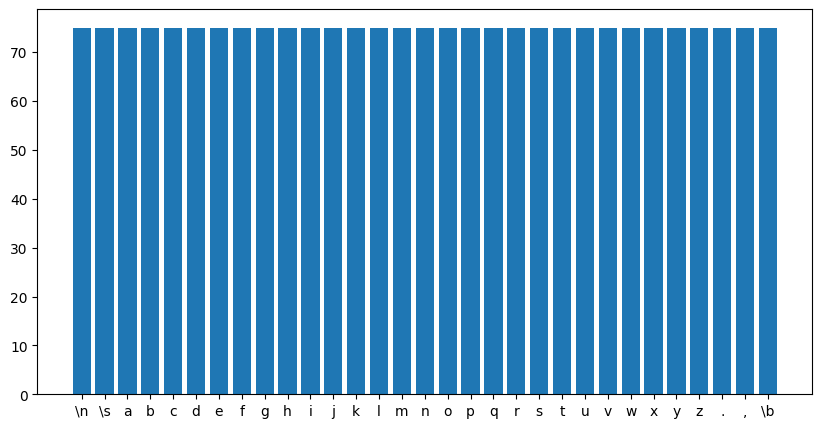

In [8]:
counts = Counter(label_encoder.inverse_transform(y))

items = list(counts.keys())
frequencies = list(counts.values())

fig = plt.figure(figsize=(10, 5))
plt.bar(items, frequencies)
plt.show()

In [9]:
label_encoder.classes_

array([',', '.', '\\b', '\\n', '\\s', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
       'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't',
       'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U2')

In [11]:
ndata_train = int(0.98*ndata)
ndata_eval = int(0.02*ndata)

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=ndata_eval, random_state=42, stratify=y)

In [12]:
x_temp = x_train.reshape([-1, nchannels])
x_temp = x_temp[~np.any(np.isnan(x_temp), axis=1), :]
mean_arr = x_temp.mean(axis=0)
std_arr = x_temp.std(axis=0)

In [13]:
x_train_n = (x_train-mean_arr)/std_arr
x_eval_n = (x_eval-mean_arr)/std_arr
x_train_n[np.isnan(x_train_n)] = 0
x_eval_n[np.isnan(x_eval_n)] = 0

x_train_n = torch.tensor(x_train_n.transpose([0, 2, 1]), dtype=torch.float32)
x_eval_n = torch.tensor(x_eval_n.transpose([0, 2, 1]), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_eval = torch.tensor(y_eval, dtype=torch.long)

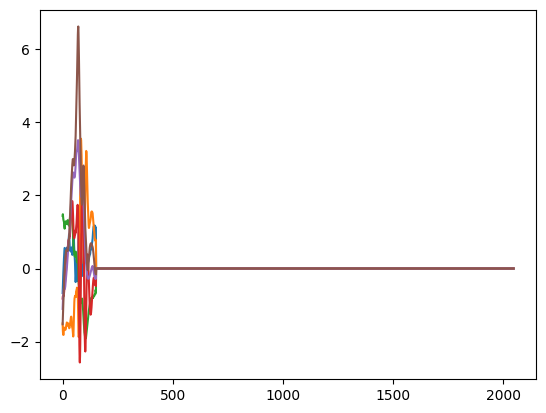

In [14]:
temp = (x_train-mean_arr)/std_arr
temp[np.isnan(temp)] = 0
plt.plot((temp[25, :, :]))
plt.show()

In [15]:
def seed_worker(worker_id):
    np.random.seed(43 + worker_id)
    random.seed(43 + worker_id)

In [16]:
train_dataset = TensorDataset(x_train_n, y_train)
eval_dataset = TensorDataset(x_eval_n, y_eval)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
eval_dataloader = DataLoader(eval_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)

In [17]:
model = globals()[model_name.split('_')[0]](nchannels=nchannels, nclasses=nclasses, feature_extraction=feature_extraction).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
nepoch = 50
train_loss_list = []
eval_loss_list = []
train_accuracy_list = []
eval_accuracy_list = []

for epoch in range(nepoch):
    model.train()
    train_loss = 0
    i = 0
    for (inputs, labels) in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        i += torch.sum(preds==labels).item()
    train_loss_list.append(train_loss/len(train_dataloader))
    train_accuracy_list.append(i/ndata_train)

    model.eval()
    eval_loss = 0
    i = 0
    with torch.no_grad():
        for (inputs, labels) in eval_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
            i += torch.sum(preds==labels).item()
    eval_loss_list.append(eval_loss/len(eval_dataloader))
    eval_accuracy_list.append(i/ndata_eval)
    print(f'Epoch [{epoch+1}/{nepoch}], Train Loss: {train_loss_list[-1]}, Eval Loss: {eval_loss_list[-1]}')

Epoch [1/50], Train Loss: 3.053751071294149, Eval Loss: 3.443460464477539
Epoch [2/50], Train Loss: 1.7129072745641072, Eval Loss: 1.4779704809188843
Epoch [3/50], Train Loss: 0.6536508285337024, Eval Loss: 0.4067394435405731
Epoch [4/50], Train Loss: 0.3617085764805476, Eval Loss: 0.15638457238674164
Epoch [5/50], Train Loss: 0.26146940969758564, Eval Loss: 0.1557978391647339
Epoch [6/50], Train Loss: 0.18914553109142515, Eval Loss: 0.15363731980323792
Epoch [7/50], Train Loss: 0.14825273677706718, Eval Loss: 0.09338729083538055
Epoch [8/50], Train Loss: 0.14315431316693625, Eval Loss: 0.3367714583873749
Epoch [9/50], Train Loss: 0.1175263441271252, Eval Loss: 0.24342912435531616
Epoch [10/50], Train Loss: 0.08961564074787828, Eval Loss: 0.07928863167762756
Epoch [11/50], Train Loss: 0.0698094308997194, Eval Loss: 0.1282285451889038
Epoch [12/50], Train Loss: 0.07933992385450336, Eval Loss: 0.11245105415582657
Epoch [13/50], Train Loss: 0.06996826444649035, Eval Loss: 0.22314295172691

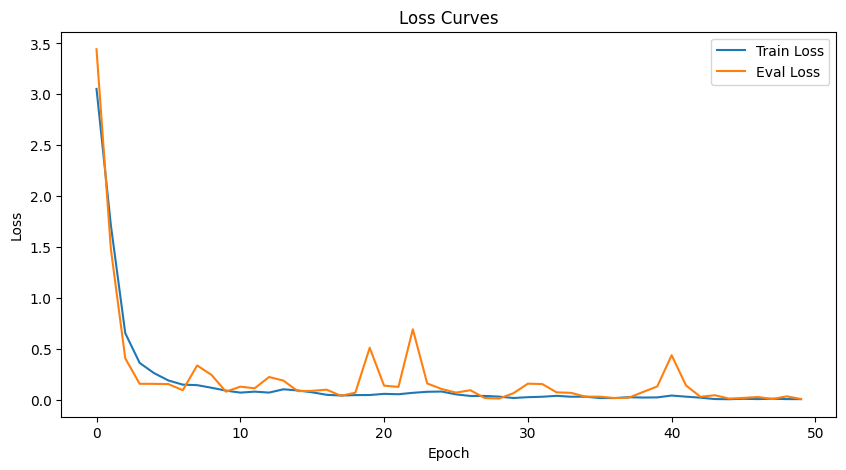

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(nepoch), train_loss_list, label='Train Loss')
plt.plot(range(nepoch), eval_loss_list, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

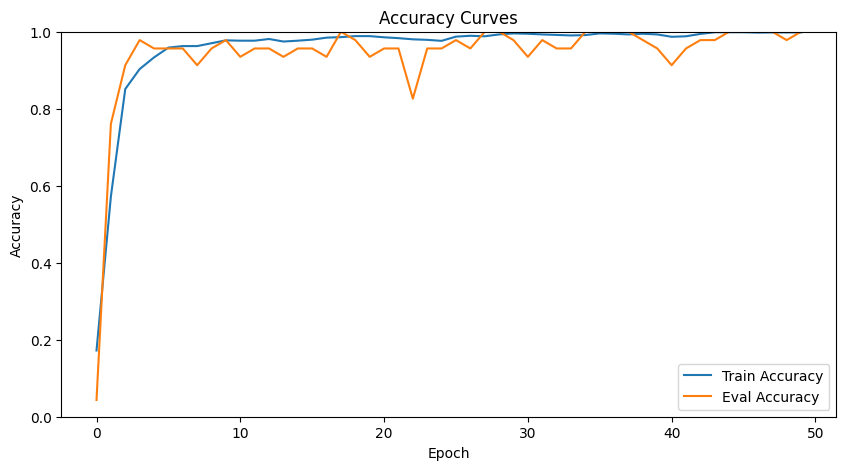

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(nepoch), train_accuracy_list, label='Train Accuracy')
plt.plot(range(nepoch), eval_accuracy_list, label='Eval Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [21]:
train_accuracy_list[-1]

0.9982440737489026

In [22]:
eval_accuracy_list[-1]

1.0

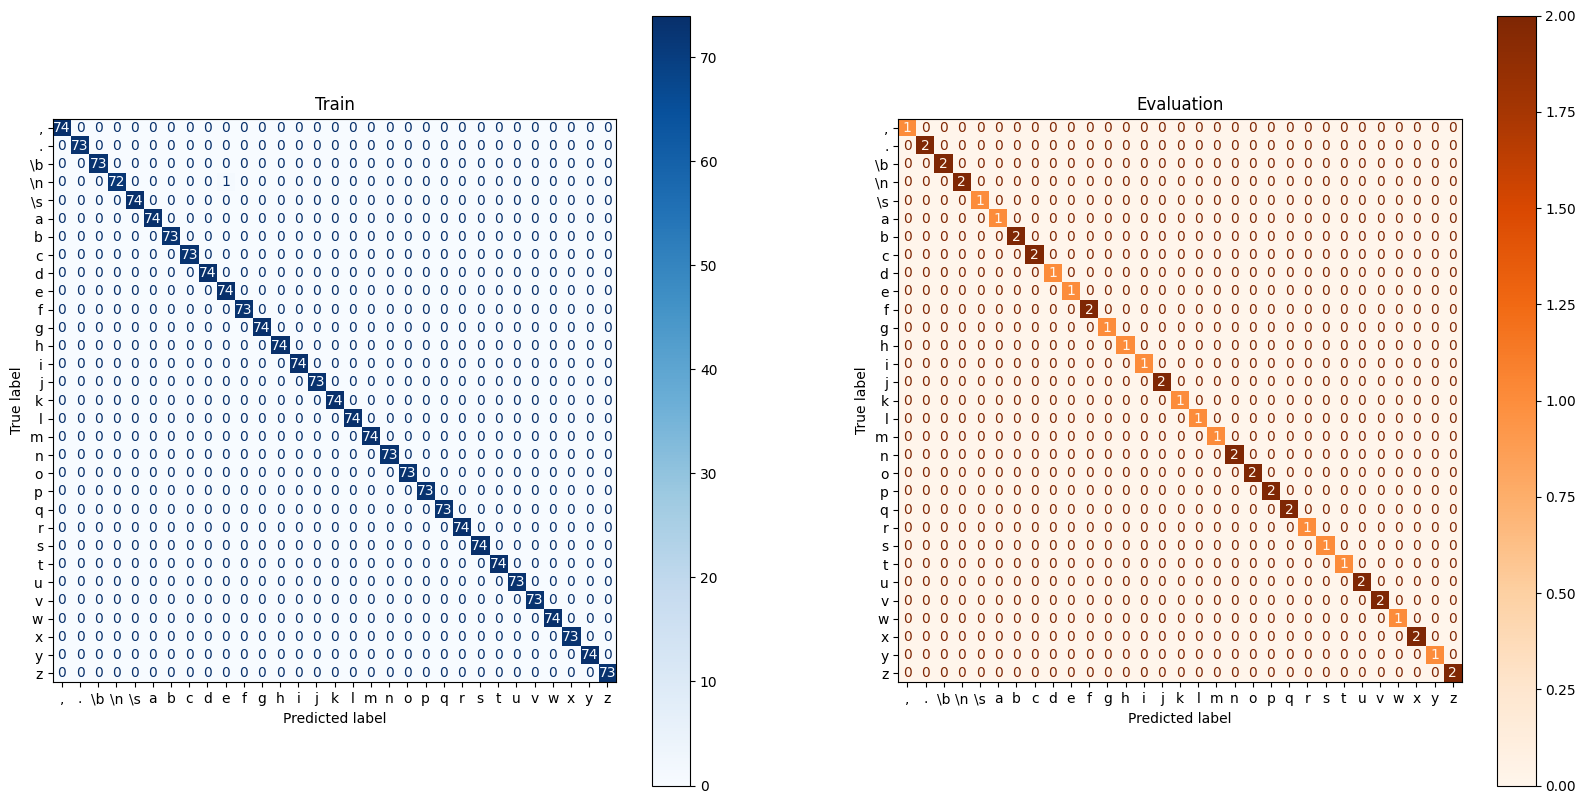

In [23]:
model.eval()
train_preds = []
train_labels = []
eval_preds = []
eval_labels = []
with torch.no_grad():
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        train_preds.append(preds.cpu())
        train_labels.append(labels.cpu())
    for inputs, labels in eval_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        eval_preds.append(preds.cpu())
        eval_labels.append(labels.cpu())

train_preds = torch.cat(train_preds)
train_labels = torch.cat(train_labels)

eval_preds = torch.cat(eval_preds)
eval_labels = torch.cat(eval_labels)

# Confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
cm_train = confusion_matrix(train_labels.cpu(), train_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_encoder.classes_)
disp.plot(ax=axs[0], cmap='Blues')
axs[0].set_title('Train')

cm_eval = confusion_matrix(eval_labels.cpu(), eval_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eval, display_labels=label_encoder.classes_)
disp.plot(ax=axs[1], cmap='Oranges')
axs[1].set_title('Evaluation')
# plt.tight_layout()
plt.show()

In [24]:
folder_path = 'Models'
if(input('Do you want to save the model?(y/n): ')=='y'):
        variables_full_path = folder_path+'/'+model_name+'.pkl'
        model_full_path = folder_path+'/'+model_name+'.pth'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        with open(variables_full_path, 'wb') as f:         
            pickle.dump({'feature_extraction': feature_extraction, 'label_encoder': label_encoder, 'mean_arr': mean_arr, 'std_arr': std_arr}, f)
        torch.save(model.state_dict(), model_full_path)